In [63]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-talk', 'seaborn-ticks'])

import cartopy.crs as ccrs

import numpy as np
import pandas as pd
import xarray as xr

import warnings; warnings.simplefilter('ignore')

import air_quality.models.hawkins_sutton2012 as hs

This is a continuation notebook of [13_hawkins_sn.ipynb](13_hawkins_sn.ipynb). Here, we apply the hierarchical clustering technique to our air quality data and then use the resulting clusters to build our regression model.

# Pre-process data

We'll include a few different data sources for our model, including both the seasonal cycle as well as multiple timeseries.

## Regressions

We want to use the correlation and regression coefficients between temperature and ozone in our dataset. It would be useful to see if there are differences at different parts of the season, though, so we'll compute an annual regression separately from ones looking at each month individually. We'll also analyse this across our ensemble members and treat each decade separately.

In [2]:
from darpy import shift_lons
from air_quality.util import fgm_unstack_years, flatten_times

fields = ['TREFHT', 'O3_SRF', ]
scales = [1., 1e9, ]


data = xr.open_dataset(
    "../data/processed/fgm.air_quality.monthly.nc",
    chunks={'lat': 48, 'lon': 72}
)
data = data[fields].squeeze()
for field, scale in zip(fields, scales):
    print(field, scale)
    data[field] *= scale

#  data = fgm_unstack_years(data)
# data = shift_lons(data).roll(lon=len(data.lon)//2 - 1)

merged = data.copy().load()

TREFHT 1.0
O3_SRF 1000000000.0


In [3]:
from air_quality.analysis import regress_fields

x = 'TREFHT'
y = 'O3_SRF'

Before running any of hte following cells, it would be useful to check that we're using the joblib powered vectorization inside `regress_fields()`, and that we're running on a cluster; even maxing out a single node dramatically speeds up these calculations.

### Decadal-resolved

#### Annual

In [28]:
# ann_regress = regress_fields(merged, x, y)
# ann_regress = ann_regress.drop(fields)
# ann_regress.to_netcdf("../data/processed/fgm.{}-vs-{}.annual.ensemble.nc"
#                       .format(y, x))

# ann_regress_pooled = regress_fields(
#     flatten_times(merged, aux_times='ic'), x, y
# )
# ann_regress_pooled = ann_regress_pooled.drop(fields)
# ann_regress_pooled.to_netcdf(
#     "../data/processed/fgm.{}-vs-{}.annual.pooled.nc".format(y, x)
# )

ann_regress_ensemble_mean = regress_fields(merged.mean('ic'), x, y)
ann_regress_ensemble_mean = ann_regress_ensemble_mean.drop(fields)
ann_regress_ensemble_mean.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.annual.ensemble_mean.nc".format(y, x)
)


syncing


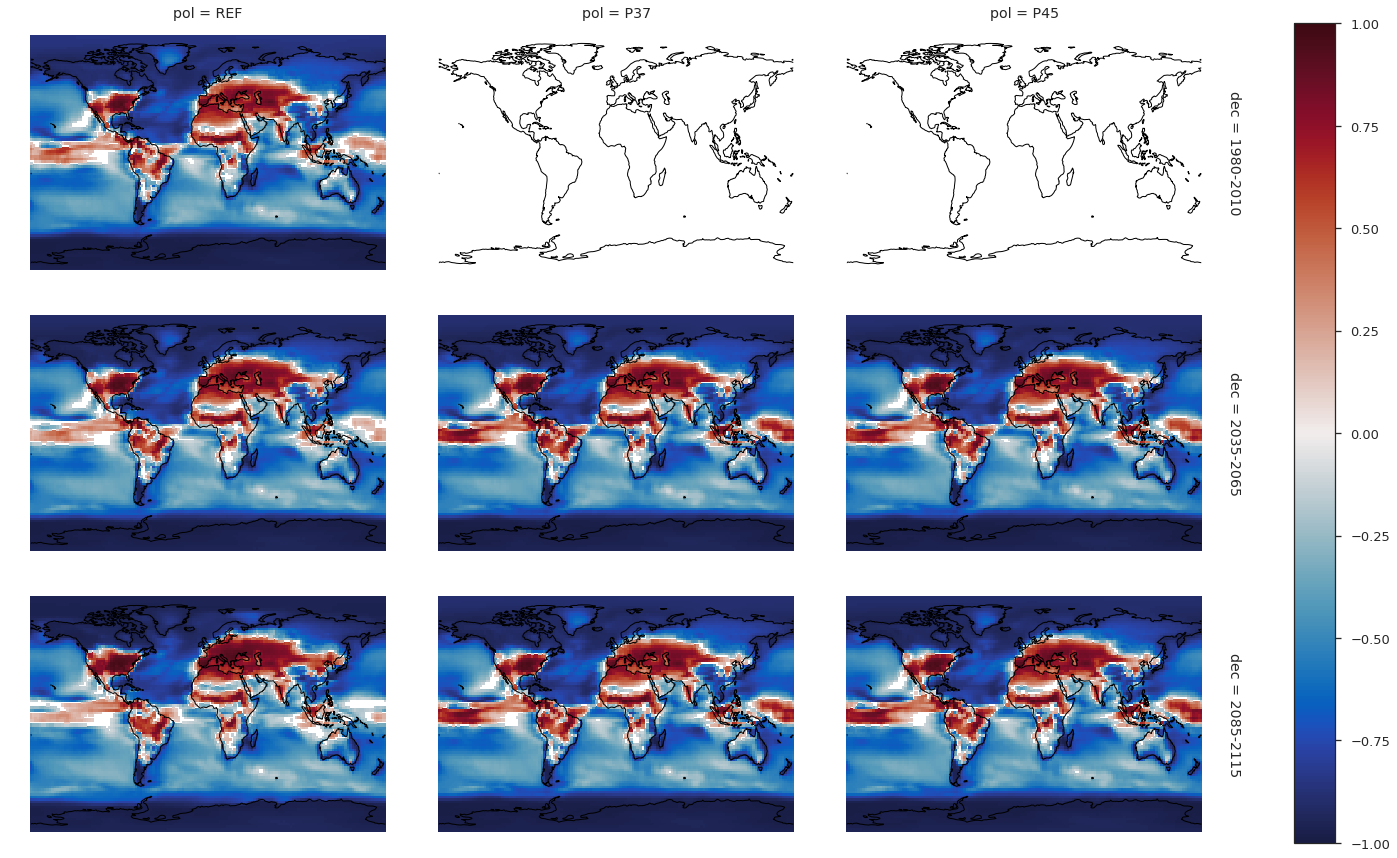

In [8]:
import cmocean

_ds = ann_regress_pooled
d = _ds.r_O3_SRF_TREFHT
d = d.where(_ds.p_O3_SRF_TREFHT < 0.05)
g = d.plot.pcolormesh('lon', 'lat', row='dec', col='pol',cmap=cmocean.cm.balance,
                      size=4., aspect=1.7, vmin=-1., vmax=1.,
                      subplot_kws=dict(
                          projection=ccrs.PlateCarree(), aspect='auto'
                      ), transform=ccrs.PlateCarree())
for ax in g.axes.ravel():
    ax.coastlines()
    ax.outline_patch.set_visible(False)

#### Monthly

In [21]:
# Ensemble
print("Ensemble")
monthly = []
for month in range(1, 13):
    print("   ", month)
    _ds = merged.where(merged['time.month'] == month, drop=True)
    _m = regress_fields(_ds, x, y)
    _m['month'] = month
    monthly.append(_m.drop(fields + ['time', ]))
monthly = xr.concat(monthly, 'month')
monthly.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.monthly.ensemble.nc"
    .format(y, x)
)

# Pooled
print("Pooled")
monthly = []
for month in range(1, 13):
    print("   ", month)
    _ds = flatten_times(
        merged.where(merged['time.month'] == month, drop=True),
        aux_times='ic'
    ).drop('ic')
    _m = regress_fields(_ds, x, y)
    _m['month'] = month
    monthly.append(_m.drop(fields + ['time', ]))
monthly = xr.concat(monthly, 'month')
monthly.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.monthly.pooled.nc"
    .format(y, x)
)

# Mean
print("Mean")
monthly = []
for month in range(1, 13):
    print("   ", month)
    _ds = merged.where(merged['time.month'] == month, drop=True).mean('ic')
    _m = regress_fields(_ds, x, y)
    _m['month'] = month
    monthly.append(_m.drop(fields + ['time', ]))
monthly = xr.concat(monthly, 'month')
monthly.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.monthly.ensemble_mean.nc"
    .format(y, x)
)

Pooled
    1

    2

    3

    4

    5

    6

    7

    8

    9

    10

    11

    12

syncing
Mean
    1

    2

    3

    4

    5

    6

    7

    8

    9

    10

    11

    12

syncing


In [44]:
from darpy import shift_lons
d = monthly.m_O3_SRF_TREFHT
d = d.where(monthly.p_O3_SRF_TREFHT < 0.05)
d = shift_lons(d).roll(lon=len(d.lon)//2 - 1)

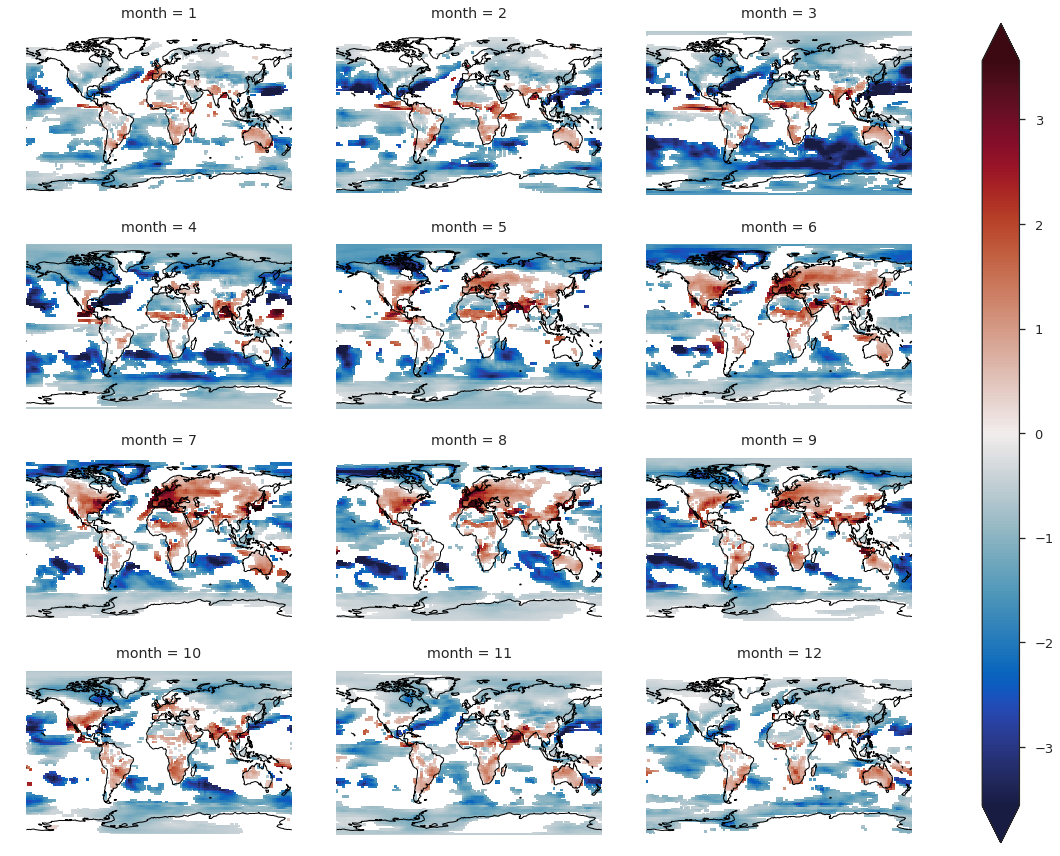

In [53]:
g = (
    d
    .isel(dec=0, pol=0)
    .plot.pcolormesh('lon', 'lat', col='month', col_wrap=3, infer_intervals=True,
                     cmap=cmocean.cm.balance,
                     size=3., aspect=1.7, robust=True, # vmin=-1., vmax=1.,
                     subplot_kws=dict(
                         projection=ccrs.PlateCarree(), aspect='auto'
                     ), transform=ccrs.PlateCarree())
)
for ax in g.axes.ravel():
    ax.coastlines()
    ax.outline_patch.set_visible(False)

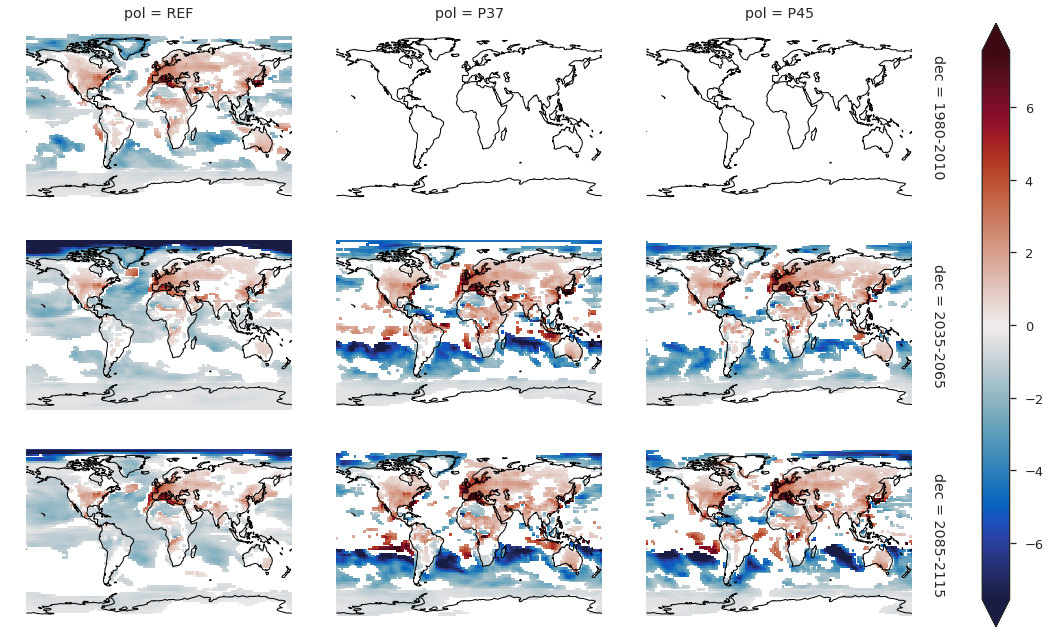

In [54]:
g = (
    d
    .isel(month=6)
    .plot.pcolormesh('lon', 'lat', col='pol', row='dec', infer_intervals=True,
                     cmap=cmocean.cm.balance,
                     size=3., aspect=1.7, robust=True, # vmin=-1., vmax=1.,
                     subplot_kws=dict(
                         projection=ccrs.PlateCarree(), aspect='auto'
                     ), transform=ccrs.PlateCarree())
)
for ax in g.axes.ravel():
    ax.coastlines()
    ax.outline_patch.set_visible(False)

---

### Long-term

In [99]:
from air_quality.util import flatten_times

# Clip out the last year since we're missing December for it.
nt = len(data.time)
data_lt = data.isel(time=slice(None, -(nt % 12))).load()

# Copy in the 1980-2010 data for each of the non-REF policy cases
for field in data_lt.data_vars:
    for pol in ['P37', 'P45']:
        data_lt.sel(dec='1980-2010', pol=pol)[field].values[:] = \
            data_lt.sel(dec='1980-2010', pol='REF')[field]

# Flatten times
data_lt = flatten_times(data_lt, aux_times='dec').copy().load()

Just a sanity check that we copied the data correctly

In [56]:
from darpy import global_avg

df = global_avg(data_lt['TREFHT']).to_dataframe('TREFHT').reset_index()

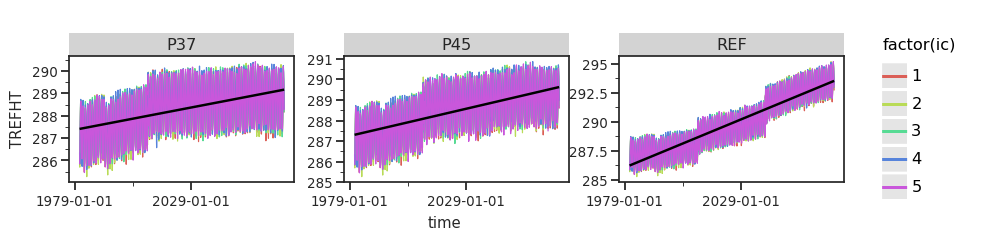

<ggplot: (-9223363301583262197)>

In [57]:
from plotnine import *
                
# Don't include the coloring in the default aesthetic so that we can easily 
# linear model over all 5 cases
p = (ggplot(data=df, mapping=aes('time', 'TREFHT'))
 # Need to use factor(ic) to indicate that it's discrete
 + geom_line(mapping=aes(color='factor(ic)'))
 + geom_smooth(method='lm')
 + facet_wrap('pol', scales='free_y')
 + theme_seaborn(style='ticks', context='talk', font_scale=0.75)
 + theme(
     aspect_ratio=1./(16./9.), figure_size=(10., 5.),
     panel_spacing_x=0.5,   
 )
)
p


#### Annual

In [58]:
ann_regress = regress_fields(data_lt, x, y)
ann_regress = ann_regress.drop(fields)
ann_regress.to_netcdf("../data/processed/fgm.{}-vs-{}.annual.ensemble.all_years.nc"
                      .format(y, x))

ann_regress_pooled = regress_fields(
    flatten_times(data_lt, aux_times='ic'), x, y
)
ann_regress_pooled = ann_regress_pooled.drop(fields)
ann_regress_pooled.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.annual.pooled.all_years.nc".format(y, x)
)

ann_regress_ensemble_mean = regress_fields(data_lt.mean('ic'), x, y)
ann_regress_ensemble_mean = ann_regress_ensemble_mean.drop(fields)
ann_regress_ensemble_mean.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.annual.ensemble_mean.all_years.nc".format(y, x)
)


syncing

syncing

syncing


#### Monthly

In [ ]:
# Ensemble
print("Ensemble")
monthly = []
for month in range(1, 13):
    print("   ", month)
    _ds = data_lt.where(data_lt['time.month'] == month).dropna('time')
    _m = regress_fields(_ds, x, y)
    _m['month'] = month
    monthly.append(_m.drop(fields))
monthly = xr.concat(monthly, 'month')
monthly.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.monthly.ensemble.all_years.nc"
    .format(y, x)
)

# Pooled
print("Pooled")
monthly = []
for month in range(1, 13):
    print("   ", month)
    _ds = flatten_times(
        data_lt.where(data_lt['time.month'] == month).dropna('time'),
        aux_times='ic'
    )
    _m = regress_fields(_ds, x, y)
    _m['month'] = month
    monthly.append(_m.drop(fields + ['ic', 'time']))
monthly = xr.concat(monthly, 'month')
monthly.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.monthly.pooled.all_years.nc"
    .format(y, x)
)

# Mean
print("Mean")
monthly = []
for month in range(1, 13):
    print("   ", month)
    _ds = data_lt.where(data_lt['time.month'] == month).dropna('time').mean('ic')
    _m = regress_fields(_ds, x, y)
    _m['month'] = month
    monthly.append(_m.drop(fields + ['time', ]))
monthly = xr.concat(monthly, 'month')
monthly.to_netcdf(
    "../data/processed/fgm.{}-vs-{}.monthly.ensemble_mean.all_years.nc"
    .format(y, x)
)

## Data QC Check

As a sanity check, plot the global average timeseries of given fields for each ensemble member for each case; this will let us know if we're missing any data.

In [5]:
annual_cycle_data = xr.open_dataset("../data/processed/annual_cycle/fgm.cycle.nc")
# seasons = ['DJF', 'JJA', 'SON', 'MAM']
seasons = ['winter', 'summer']

def load_seasonal_timeseries(season, field):
    ds = xr.open_dataset("../data/processed/seasonal_timeseries/fgm.{field}.{season}.nc"
                         .format(field=field, season=season))
    ds['season'] = season
    return ds

all_data = []
for season in seasons:
    print(season)
    seasonal_data = []
    for field in annual_cycle_data.data_vars:
        ds = xr.open_dataset("../data/processed/seasonal_timeseries/fgm.{field}.{season}.nc"
                             .format(field=field, season=season))
        seasonal_data.append(ds)
    ds = xr.auto_combine(seasonal_data)
    # ds = hs.fgm_unstack_years(ds)
    ds['season'] = season
    for key in ['year', 'lev']:
        if key in ds:
            ds = ds.reset_coords(key, drop=True)
    all_data.append(ds)
seasonal_ts_data = xr.concat(all_data, 'season')


winter
summer


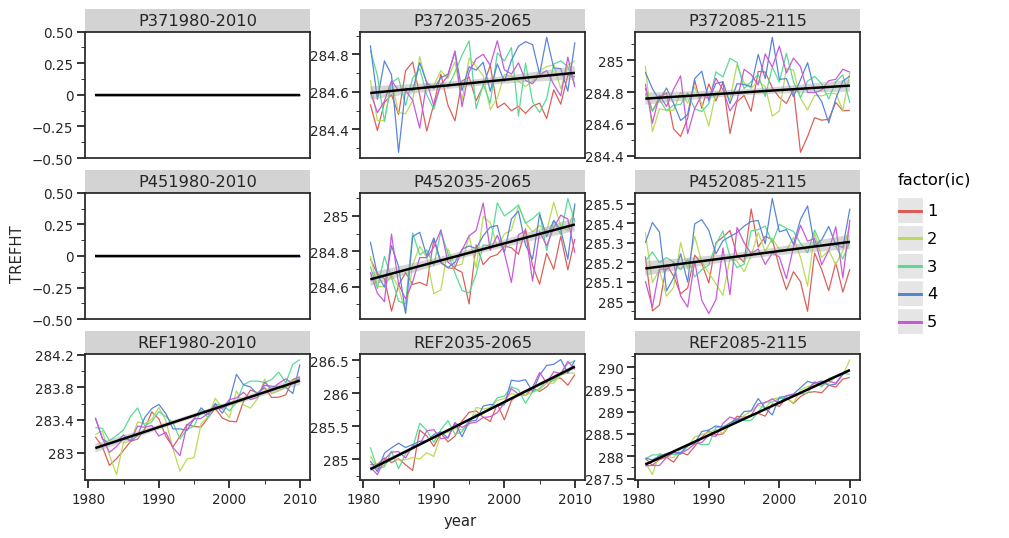

<ggplot: (8791778628998)>

In [17]:
from plotnine import *
from darpy import global_avg

field = 'TREFHT'
scale = 1
season = 'winter'
df = global_avg(seasonal_ts_data[field].sel(season=season)).to_dataframe(field).reset_index()
df['year'] = df['time']#.dt.year
df[field] *= scale

# Don't include the coloring in the default aesthetic so that we can easily 
# linear model over all 5 cases
p = (ggplot(data=df, mapping=aes('year', field))
 # Need to use factor(ic) to indicate that it's discrete
 + geom_line(mapping=aes(color='factor(ic)'))
 + geom_smooth(method='lm')
 # + scale_x_date()
 + facet_wrap('pol + dec', scales='free_y')
 + theme_seaborn(style='ticks', context='talk', font_scale=0.75)
 + theme(
     aspect_ratio=1./(16./9.), figure_size=(10., 5.),
     panel_spacing_x=0.5,   
 )
)
# p.save("../figs/fgm.compare_global_avg_timeseries.{field}.{season}.png"
#        .format(field=field, season=season), dpi=120,
#        bbox_inches='tight', transparent=True)
p


# Load data

In [3]:
from darpy import landsea_mask
from air_quality.util import shift_roll

monthly_regress = (
    xr.open_dataset("../data/processed/fgm.O3_SRF-vs-TREFHT.monthly.ensemble_mean.nc")
    # .pipe(shift_roll)
)
monthly_cycle = (
    xr.open_dataset("../data/processed/annual_cycle/fgm.cycle.nc")
    .mean('ic')
    # .pipe(shift_roll)
)

# Get a land/sea continent mask and re-map from boolean to integers
lsm = (
    landsea_mask(monthly_regress)
    .transpose('lat', 'lon')
    .astype('int')
    # .pipe(shift_roll)    
)


# Cluster

To fit the data, we'll use the land/sea masks to build a connectivity matrix of connected grid cells. Then, to begin with, we can train clusters using the seasonal cycle of monthly mean ozone data from the present day. We can then use [a pipeline](http://maciejjaskowski.github.io/2016/01/22/pandas-scikit-workflow.html) to automate the transformations and clustering). Some additional pipeline resources:

- [sklearn pipeline](http://signal-to-noise.xyz/post/sklearn-pipeline/)
- [Pipelines and FeatureUnions](http://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html)

In [3]:
from sklearn.feature_extraction import grid_to_graph
from air_quality.models.hawkins_sutton2012 import periodic_x_connectivity_matrix

field = 'O3_SRF'
scale = 1e9
# field = 'TREFHT'
# scale = 1

_landsea = (
    lsm
    .to_dataframe('landsea')
)

# Compute connectivity matrices
# 1) Total connectivity matrix
conn_total_orig = grid_to_graph(*lsm.shape)
conn_total = periodic_x_connectivity_matrix(
    # THIS WORKS!
    *lsm.shape[::-1], order='F'
    # THIS DOESN'T!
    # *lsm.shape, order='C'
)

# 2) Separate land/ocean
from scipy.sparse import block_diag
conn_ocn = grid_to_graph(*lsm.shape, mask=lsm.values)
conn_lnd = grid_to_graph(*(~lsm).shape, mask=(~lsm.astype('bool')).values)
block_diag([conn_ocn, conn_lnd])

_monthly_cycle_data = (
    (monthly_cycle[field] * scale)
    .sel(dec='1980-2010', pol='REF')
    .to_dataframe()[[field, ]]
    .unstack('month')[field]
    .add_prefix("present_")
)

rfld = "r_{}_{}".format(field, 'TREFHT')
_monthly_regress_data = (
    monthly_regress[rfld]
    .sel(dec='1980-2010', pol='REF')
    .to_dataframe()[[rfld, ]]
    .unstack('month')[rfld]
    .add_prefix("present_r_")
)

_clustering_df = pd.concat([
    _monthly_cycle_data, 
#     _monthly_regress_data, 
    _landsea
], axis=1)

ref = _clustering_df.copy().reset_index()[['lon', 'lat']].copy()
def back_to_xarray(y, name='data'):
    return (
        ref
        .set_index(['lat', 'lon'])
        .assign(**{name: y})
        .sortlevel()
        .to_xarray()
    )   

# No sort
_clustering_df = _clustering_df.reset_index().drop(['lon', 'lat'], axis=1)

# Sort lnd -> ocean
# _clustering_df = pd.concat([
#     _clustering_df.loc[_clustering_df.landsea == 0],
#     _clustering_df.loc[_clustering_df.landsea == 1],
# ])
# _lat_lon_ref  = _clustering_df.index
# _clustering_df = _clustering_df.reset_index().drop(['lon', 'lat'], axis=1)
# def arr_to_series(y):
#     return pd.Series(y, index=_lat_lon_ref)


Map pre-processing routines.

In [4]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

mapper = DataFrameMapper([
    (['landsea', ], OneHotEncoder()),
    (['present_{:d}'.format(i+1) for i in range(12)], MinMaxScaler()),
#     (['present_r_{:d}'.format(i+1) for i in range(12)], MinMaxScaler())
],
# default=MinMaxScaler()
)

# mapper.fit_transform(_clustering_df)

In [5]:
from sklearn.grid_search import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import make_scorer


cluster_pipeline = Pipeline([
    ('mapper', mapper),
    ('clusterer', AgglomerativeClustering(n_clusters=40, linkage='ward',
                                          connectivity=conn_total, 
                                          compute_full_tree=True)),
])

# full_params = {
#     'clusterer__n_clusters': list(range(5, 41)),
# }
# scorer = make_scorer(adjusted_mutual_info_score)
# gs_pipeline = GridSearchCV(cluster_pipeline, full_params, n_jobs=-1,
#                            scoring=scorer, cv=0, verbose=1)

# for n_clusters in range

/home/darothen/software/miniconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/darothen/software/miniconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
import tqdm
from sklearn.metrics import silhouette_samples, silhouette_score

X = mapper.fit_transform(_clustering_df)

all_clusters = []
# n_clusters_iter = [4, 8, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60] 
n_clusters_iter = [32, ]
for n_clusters in tqdm.tqdm(n_clusters_iter):
    clusterer = AgglomerativeClustering(n_clusters, 
                                        linkage='ward', 
                                        connectivity=conn_total,
                                        compute_full_tree=True)
    pred = clusterer.fit_predict(X)
    # pred_ds = back_to_xarray(arr_to_series(pred), 'cluster')
    pred_ds = back_to_xarray(pred, 'cluster')
    pred_ds['n_clusters'] = n_clusters
    
    # This is expensive. There are probably better metrics to use.
    # silhouette_avg = silhouette_score(X, pred)
    # pred_ds['silhouette_avg'] = silhouette_avg
    
    all_clusters.append(pred_ds)
clustering_result = xr.auto_combine(all_clusters, 'n_clusters')

  0%|          | 0/1 [00:00<?, ?it/s]100%|██████████| 1/1 [00:07<00:00,  7.64s/it]


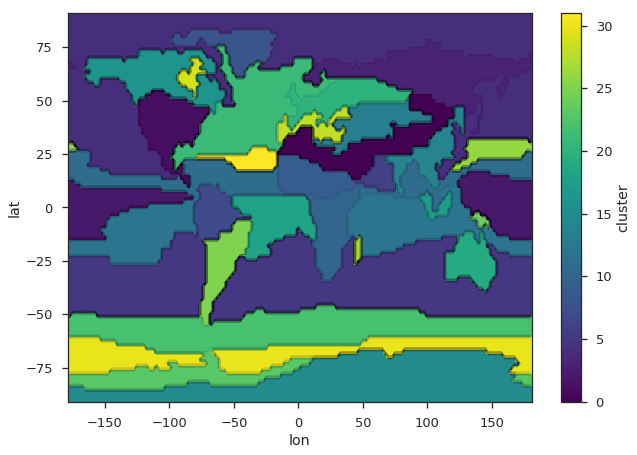

In [7]:
from air_quality.util import shift_roll

n_clusters = 32
clusters = clustering_result.cluster#.sel(n_clusters=n_clusters)
clusters.pipe(shift_roll).plot.contour(colors='k', linewidths=0.1, levels=range(n_clusters))
clusters.pipe(shift_roll).plot.pcolormesh(infer_intervals=True)

# plt.savefig("../figs/ward_cluster.periodic.example.png",
#             dpi=120, transparent=True, bbox_inches='tight')


## Periodic Comparison

**Sample - periodic vs non-periodic boundaries**

In [ ]:
n_clusters = 32
clusterer = AgglomerativeClustering(n_clusters, 
                                    linkage='ward', 
                                    connectivity=conn_total,
                                    compute_full_tree=True)
_periodic = clusterer.fit_predict(X)
_periodic = back_to_xarray(_periodic, 'cluster')

clusterer = AgglomerativeClustering(n_clusters, 
                                    linkage='ward', 
                                    connectivity=conn_total_orig,
                                    compute_full_tree=True)
_non_periodic = clusterer.fit_predict(X)
_non_periodic = back_to_xarray(_non_periodic, 'cluster')

In [891]:
combined = xr.concat([_periodic, _non_periodic],
                     dim=pd.Index(['periodic', 'non-periodic'], name='periodic'))
combined = shift_roll(combined)

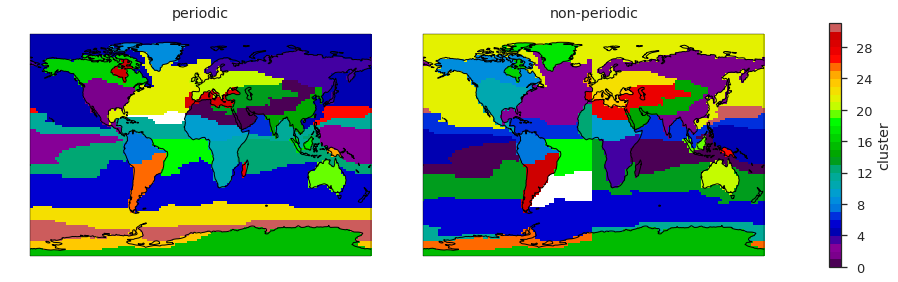

In [905]:
g = (
    combined['cluster']
    .plot.pcolormesh(
        x='lon', y='lat', col='periodic',
        size=4., aspect=1.6, levels=range(n_clusters),
        cmap='spectral',
        subplot_kws=dict(
            projection=ccrs.PlateCarree(), aspect='auto'
        ), transform=ccrs.PlateCarree()                               
    )
)
for ax in g.axes.ravel():
    ax.coastlines()
g.set_titles(template='{value}')

plt.savefig('../figs/clustering.periodic_comparison.png', dpi=120,
            transparent=True, bbox_inches='tight')

## Evaluation

Using our clusters, we can now look into statistics of what's happening in each cluster.

In [20]:
import xarray as xr
from air_quality.util import fgm_unstack_years

data_timeseries = xr.open_dataset("../data/processed/seasonal_timeseries/fgm.O3_SRF.JJA.nc")
data_timeseries = data_timeseries * 1e9
clustering_result = xr.open_dataset("../data/fgm.clusters.test.nc")

_to_model = fgm_unstack_years(data_timeseries).sel(pol='REF', ic=1)
_to_model['cluster'] = clustering_result.cluster
_to_model['n_clusters'] = clustering_result.n_clusters
_to_model = _to_model.set_coords(['cluster', ])

First we compute the in-cluster average timeseries

In [26]:
from darpy import global_avg
import tqdm
import numpy as np

avgs = []
stds = []
for cluster in tqdm.tnrange(n_clusters, leave=False):
    subset = _to_model.where(_to_model.cluster == cluster)
    avg = global_avg(subset).rename({'O3_SRF': 'avg'})['avg']
    std = subset.std(['lon', 'lat']).rename({'O3_SRF': 'std'})['std']

    avgs.append(avg)
    stds.append(std)

avgs = xr.concat(avgs, 'cluster').to_dataset()
stds = xr.concat(stds, 'cluster').to_dataset()
cluster_data = xr.auto_combine([avgs, stds])

### Trends by Cluster

### Widget

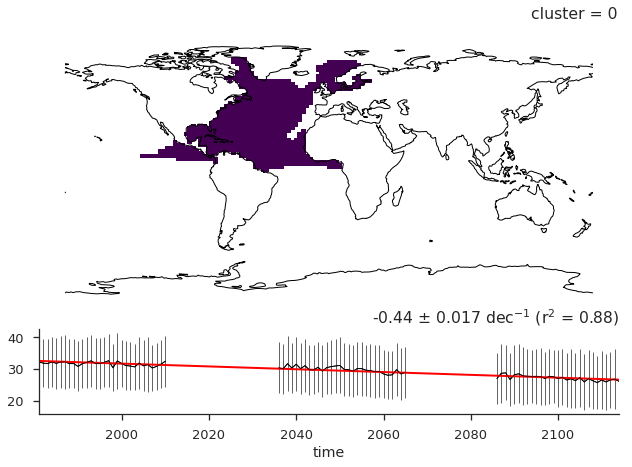

In [854]:
from ipywidgets import interactive, IntSlider, Dropdown
from matplotlib.gridspec import GridSpec
from air_quality.models.hawkins_sutton2012 import HawkinsSutton2012
from scipy.stats import linregress
import seaborn as sns

model = HawkinsSutton2012._model

cluster_slider = IntSlider(min=0, max=4)
n_clusters_slider = Dropdown(description='n_clusters',
    options=list(_to_model.n_clusters.values.astype('int'))
)
def update_cluster_range(*args):
    cluster_slider.max = n_clusters_slider.value
n_clusters_slider.observe(update_cluster_range, 'value')

def geo_trend(cluster=0, n_clusters=12):

    plt.close('all')
    fig = plt.figure()
    gs = GridSpec(4, 4)
    ax = fig.add_subplot(gs[:-1, :], projection=ccrs.PlateCarree())

    _clusters = _to_model.cluster.sel(n_clusters=int(n_clusters))
    _clusters.where(_clusters == cluster).pipe(shift_roll).plot.pcolormesh(
        ax=ax, infer_intervals=True, add_colorbar=False,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()
    ax.outline_patch.set_visible(False)
    ax.set_title("")
    ax.set_title("cluster = {}".format(cluster), loc='right')

    _c = all_cluster_data[int(n_clusters)].sel(cluster=cluster)
    _y = _c['avg']
    _x = _c['time']
    
    p = np.polyfit(_x, _y, 1)
    regress = linregress(_x, _y)
    xs = np.arange(_x[0], _x[-1])
    y_hat = [model(xi, p) for xi in xs]

    r = regress.rvalue
    r2 = r**2
    slope, err = regress.slope, regress.stderr
    slope *= 10 # convert from per year to per decade
    err *= 10
    stat_str = "{slope:.2g} $\pm$ {err:.2g} dec$^{{-1}}$ (r$^2$ = {r2:.2g})"
    stat_str = stat_str.format(slope=slope, err=err, r2=r2)

    # Coerce to dataframe, and re-index to continuous years
    _c_df = _c.to_dataframe().reindex(xs)
    _c_df['smoothed'] = y_hat

    # Plot
    ax2 = fig.add_subplot(gs[-1, :])
    _c_df.plot(y='avg', yerr='std', ax=ax2, color='k', lw=0.6, legend=False)
    _c_df.plot(y='avg', ax=ax2, color='k', lw=1.0, legend=False)
    _c_df.plot(y='smoothed', ax=ax2, color='r', lw=2, legend=False)
    sns.despine(ax=ax2)
    ax2.set_title(stat_str, loc='right')

    plt.show()
    
interactive(geo_trend, 
            cluster=cluster_slider, n_clusters=n_clusters_slider)


### Local Correlation with Cluster Avg

In [72]:
from joblib import Parallel, delayed
from scipy.stats import pearsonr

ref_ds = _to_model.copy()
all_dims = set(ref_ds.dims)
stack_dims = list(all_dims - set(['time', ]))
stack_dim = '_temp'
_stacked = ref_ds.stack(**{stack_dim: stack_dims})

_stacked = _stacked.transpose(stack_dim, 'time')
new_data = _stacked.copy()

n_cells = len(_stacked[stack_dim])

Pre-compute cluster timeseries for each cluster

In [73]:
import pandas as pd

clusters = range(int(new_data.n_clusters))
all_cluster_data = [
    new_data.where(new_data.cluster == c, drop=True)
    .mean(stack_dim)
    for c in clusters
]

# Add a global average
all_cluster_data.append(new_data.mean(stack_dim))
clusters = list(clusters) + ['global' ]

all_cluster_data = xr.concat(all_cluster_data, 
                             dim=pd.Index(clusters, name='cluster'))

Do the regression for each cell versus its cluster average.

In [83]:
def _do_corr(i, cluster=None):
    _x = new_data['O3_SRF'].values[i]
    if cluster is None:
        cluster = new_data.cluster.values[i]
    try:
        _y = all_cluster_data.sel(cluster=cluster)['O3_SRF']
    except:
        return (np.nan, np.nan)
    return pearsonr(_x, _y)

cell_iter = tqdm.tnrange(n_cells)
corr_coeffs = Parallel(-1)(
    delayed(_do_corr)(i) for i in cell_iter
)
corr_coeffs = np.asarray(corr_coeffs)

corr_coeffs_global = Parallel(-1)(
    delayed(_do_corr)(i, 'global') for i in cell_iter 
)
corr_coeffs_global = np.asarray(corr_coeffs_global)


cluster_result = new_data.copy()
cluster_result['r'] = xr.DataArray(corr_coeffs[:, 0], dims=[stack_dim, ])
cluster_result['r2'] = cluster_result['r']**2
cluster_result['p'] = xr.DataArray(corr_coeffs[:, 1], dims=[stack_dim, ])

cluster_result = cluster_result.unstack(stack_dim)

global_result = new_data.copy()
global_result['r'] = xr.DataArray(corr_coeffs_global[:, 0], dims=[stack_dim, ])
global_result['r2'] = global_result['r']**2
global_result['p'] = xr.DataArray(corr_coeffs_global[:, 1], dims=[stack_dim, ])

global_result = global_result.unstack(stack_dim)

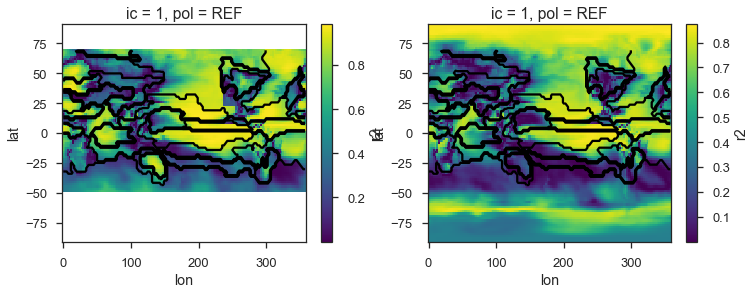

In [88]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

cluster_result.r2.plot.imshow(ax=axs[0])
cluster_result.cluster.plot.contour(ax=axs[0], colors='k')

global_result.r2.plot.imshow(ax=axs[1])
global_result.cluster.plot.contour(ax=axs[1], colors='k')

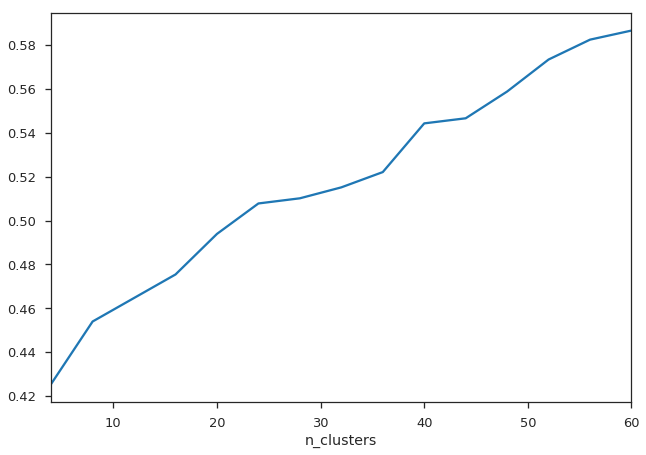

In [857]:
global_avg(new_data.r2).to_dataframe('r2')['r2'].sort_index().plot()